## Install Dependecies & Import Libraries

In [1]:
!pip install ultralytics supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 10.5 MB/s eta 0:00:00


In [2]:
import cv2
import numpy as np
import pandas as pd
import supervision as sv
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from pathlib import Path
import yaml
import shutil
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

In [3]:
!nvidia-smi

Fri Nov 14 14:57:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   58C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [5]:
from google.colab import drive
drive.mount('/content/drive')

!scp -r '/content/drive/MyDrive/Calory.v1i.yolov12.zip'

Mounted at /content/drive
usage: scp [-346ABCOpqRrsTv] [-c cipher] [-D sftp_server_path] [-F ssh_config]
           [-i identity_file] [-J destination] [-l limit]
           [-o ssh_option] [-P port] [-S program] source ... target


In [6]:
!unzip /content/drive/MyDrive/Calory.v1i.yolov12.zip

Archive:  /content/drive/MyDrive/Calory.v1i.yolov12.zip
  inflating: README.dataset.txt      
  inflating: README.roboflow.txt     
  inflating: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/1374953_jpg.rf.8780beea257937e86e1f9b689fd32964.jpg  
 extracting: test/images/1380765_jpg.rf.f2ecf9bb6cd6989872aef51a81060bd5.jpg  
 extracting: test/images/1640730_jpg.rf.5ec16c880f17774c88bf9e593f824944.jpg  
 extracting: test/images/1652710_jpg.rf.b2c421a8847ae95ca183193fd24ec650.jpg  
 extracting: test/images/1675150_jpg.rf.51a989ad07c328afe9d7a2aceb1f3d9e.jpg  
 extracting: test/images/1699065_jpg.rf.0c0ba2878b2decbe522d64e18eeb0265.jpg  
 extracting: test/images/2158248_jpg.rf.a7f7051152a886f107f7596b3c184e64.jpg  
 extracting: test/images/2168761_jpg.rf.5a2d77b84be1d89597f7fac35e9614d4.jpg  
 extracting: test/images/2177889_jpg.rf.6ec6a297cedd0e6f0bcd6a11547f022d.jpg  
 extracting: test/images/2249127_jpg.rf.fae0a6cc8f5385e4cecbb6911af8f9ac.j

## Dataset Overview

In [7]:
!ls /content/

data.yaml  README.dataset.txt	sample_data  train
drive	   README.roboflow.txt	test	     valid


In [8]:
!cat /content/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 13
names: ['Ayam Goreng -260 kal per 100 gr-', 'Capcay -67 kal per 100gr-', 'Nasi -129 kal per 100gr-', 'Sayur bayam -36 kal per 100gr-', 'Sayur kangkung -98 kal per 100gr-', 'Sayur sop -22 kal per 100gr-', 'Tahu -80 kal per 100 gr-', 'Telur Dadar -93 kal per 100gr-', 'Telur Mata Sapi -110kal1butir-', 'Telur Rebus -78kal 1butir-', 'Tempe -225 kal per 100 gr-', 'Tumis buncis -65 kal per 100gr-', 'food-z7P4']

roboflow:
  workspace: ayu-asipq
  project: calory
  version: 1
  license: CC BY 4.0
  url: https://universe.roboflow.com/ayu-asipq/calory/dataset/1

In [9]:
train_size = len(os.listdir("/content/train/images"))
test_size = len(os.listdir("/content/test/images"))
val_size = len(os.listdir("/content/valid/images"))

print(f"Train Size: {train_size} images\n")
print(f"Test Size: {test_size} images\n")
print(f"Validation Size: {val_size} images")


Train Size: 721 images

Test Size: 106 images

Validation Size: 147 images


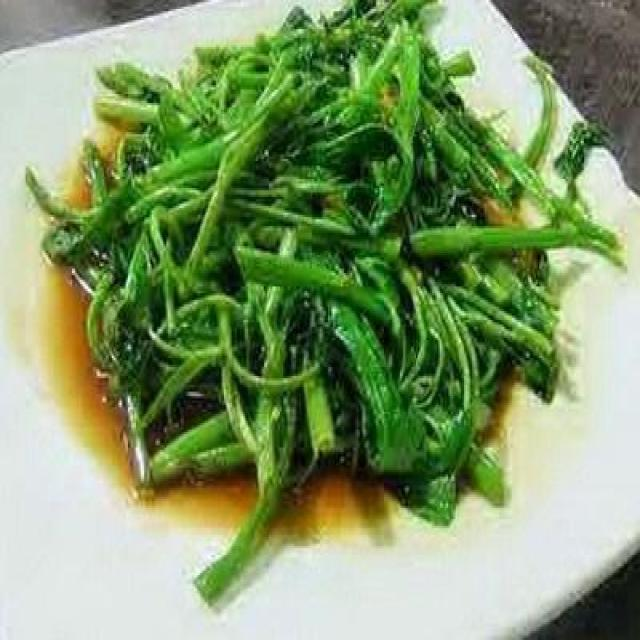

In [10]:
# Contoh image dari train data
from IPython.display import Image

Image(filename="/content/train/images/02-resep_tumis_kangkung_-bumbu_dan_cara_membuat_atau_cara_memasak_jpg.rf.448a77c779b89dfc50e6418d04b76cdc.jpg", width=500)

In [11]:
with open("/content/data.yaml", "r") as f:
  data_config = yaml.safe_load(f)

classes = data_config["names"]
print(f"Jumlah class: {len(classes)}\n")

Jumlah class: 13



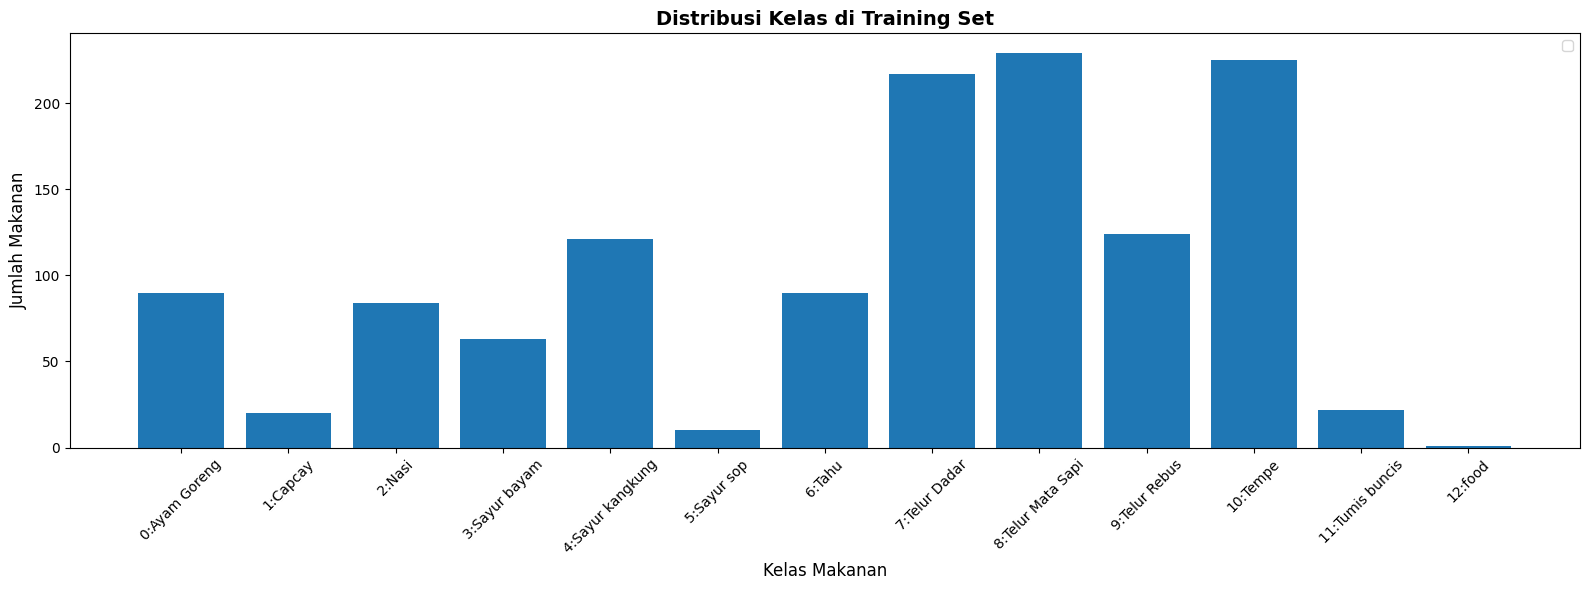

In [12]:
train_data_labels = Path("/content/train/labels/")
class_counts = {i:0 for i in range(len(classes))}
bbox_area = []

def read_yolo_format(label_path):
  annotations = []
  try:
    with open(label_path, "r") as f:
      for line in f:
        parts = line.strip().split()
        if len(parts) >= 5:
          class_id = int(parts[0])
          x_center = float(parts[1])
          y_center = float(parts[2])
          width = float(parts[3])
          height = float(parts[4])
          annotations.append({
              'class_id': class_id,
              'bbox': [x_center, y_center, width, height]
          })
  except Exception as e:
    print(f"Error: {e}")
  return annotations


for label_file in train_data_labels.glob("*.txt"):
  annotations = read_yolo_format(label_file)
  for ann in annotations:
    class_counts[ann['class_id']] += 1
    bbox_area.append(ann['bbox'][2] * ann['bbox'][3])


plt.figure(figsize=(16, 6))
class_names_short = [f"{i}:{cls.split('-')[0].strip()}" for i, cls in enumerate(classes)]
counts = [class_counts[i] for i in range(len(classes))]
bars = plt.bar(range(len(classes)), counts)

plt.xticks(range(len(classes)), class_names_short, rotation=45)
plt.xlabel('Kelas Makanan', fontsize=12)
plt.ylabel('Jumlah Makanan', fontsize=12)
plt.title('Distribusi Kelas di Training Set', fontsize=14, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()


## Data Preprocessing

Check if there are any empty labels, missing labels, corrupt images, and invalid annotations

In [13]:

def check_data_quality(images_dir, labels_dir):
    issues = {
        'corrupt_images': [],
        'missing_labels': [],
        'empty_labels': [],
        'invalid_annotations': []
    }

    images_dir = Path(images_dir)
    labels_dir = Path(labels_dir)

    image_files = list(images_dir.glob("*"))

    for img_path in image_files:
        # Check image corrupt
        try:
            img = cv2.imread(str(img_path))
            if img is None or img.size == 0:
                issues['corrupt_images'].append(img_path)
                continue
        except Exception as e:
            issues['corrupt_images'].append(img_path)
            continue

        # Check label
        label_path = labels_dir / (img_path.stem + ".txt")
        if not label_path.exists():
            issues['missing_labels'].append(img_path)
            continue

        # Check annotation validity
        annotations = read_yolo_format(label_path)
        if len(annotations) == 0:
            issues['empty_labels'].append(label_path)
        else:
            for ann in annotations:
                bbox = ann['bbox']
                if any(coord < 0 or coord > 1 for coord in bbox):
                    issues['invalid_annotations'].append(label_path)
                    break

    return issues


print("\nTraining set")
train_issues = check_data_quality("/content/train/images", "/content/train/labels")

print(f"Corrupt images: {len(train_issues['corrupt_images'])}")
print(f"Missing labels: {len(train_issues['missing_labels'])}")
print(f"Empty labels: {len(train_issues['empty_labels'])}")
print(f"Invalid annotations: {len(train_issues['invalid_annotations'])}")

print("\nValidation set")
val_issues = check_data_quality("/content/valid/images", "/content/valid/labels")

print(f"Corrupt images: {len(val_issues['corrupt_images'])}")
print(f"Missing labels: {len(val_issues['missing_labels'])}")
print(f"Empty labels: {len(val_issues['empty_labels'])}")
print(f"Invalid annotations: {len(val_issues['invalid_annotations'])}")

print("\nTesting set")
test_issues = check_data_quality("/content/test/images", "/content/test/labels")

print(f"Corrupt images: {len(test_issues['corrupt_images'])}")
print(f"Missing labels: {len(test_issues['missing_labels'])}")
print(f"Empty labels: {len(test_issues['empty_labels'])}")
print(f"Invalid annotations: {len(test_issues['invalid_annotations'])}")


Training set
Corrupt images: 0
Missing labels: 0
Empty labels: 5
Invalid annotations: 0

Validation set
Corrupt images: 0
Missing labels: 0
Empty labels: 1
Invalid annotations: 0

Testing set
Corrupt images: 0
Missing labels: 0
Empty labels: 0
Invalid annotations: 0


In [14]:
# Handle issues
train_file_issues = train_issues['empty_labels']

for fname in train_file_issues:
    if fname.exists():
        fname.unlink()
        print(f'deleted: {fname}')

validation_file_issues = val_issues['empty_labels']

for fname in validation_file_issues:
    if fname.exists():
        fname.unlink()
        print(f'deleted: {fname}')

for lbl_path in train_file_issues + validation_file_issues:
    img_filename = lbl_path.name.replace('.txt', '.jpg')
    img_path = lbl_path.parent.parent / 'images' / img_filename

    if img_path.exists():
        img_path.unlink()
        print(f'deleted image: {img_path}')
    else:
        print(f"Image not found: {img_path}")

deleted: /content/train/labels/A270201XX_01403_jpg.rf.7f164a95c0b7e616301e30a1eadd7da6.txt
deleted: /content/train/labels/A270201XX_01394_jpg.rf.e7b58354a8f0f4768f336865460fa1e3.txt
deleted: /content/train/labels/A270201XX_01419_jpg.rf.9511df3819df8a63bb799991dea42f1a.txt
deleted: /content/train/labels/IMG-mi8lite-32-_jpeg.rf.679f494632547852bfd399d8df5466d7.txt
deleted: /content/train/labels/IMG-mi8lite-42-_jpeg.rf.8468396421585f91bf35e6859d30a3f2.txt
deleted: /content/valid/labels/A270201XX_01393_jpg.rf.5a8cd5dbd74c44bdafda0de590669ce1.txt
deleted image: /content/train/images/A270201XX_01403_jpg.rf.7f164a95c0b7e616301e30a1eadd7da6.jpg
deleted image: /content/train/images/A270201XX_01394_jpg.rf.e7b58354a8f0f4768f336865460fa1e3.jpg
deleted image: /content/train/images/A270201XX_01419_jpg.rf.9511df3819df8a63bb799991dea42f1a.jpg
deleted image: /content/train/images/IMG-mi8lite-32-_jpeg.rf.679f494632547852bfd399d8df5466d7.jpg
deleted image: /content/train/images/IMG-mi8lite-42-_jpeg.rf.84

In [15]:
augmentation_pipeline = A.Compose([

    A.RandomBrightnessContrast(
        brightness_limit=0.25,
        contrast_limit=0.25,
        p=0.6
    ),

    A.HueSaturationValue(
        hue_shift_limit=15,
        sat_shift_limit=25,
        val_shift_limit=15,
        p=0.5
    ),

    A.RGBShift(
        r_shift_limit=20,
        g_shift_limit=20,
        b_shift_limit=20,
        p=0.4
    ),

    A.OneOf([
        A.GaussianBlur(blur_limit=(3,7), p=1.0),
        A.MedianBlur(blur_limit=5, p=1.0),
        A.MotionBlur(blur_limit=5, p=1.0),
    ], p=0.3),


    A.OneOf([
        A.GaussNoise(var_limit=(10.0, 50.0), p=1.0),
        A.ISONoise(color_shift=(0.01, 0.05), intensity=(0.1, 0.5), p=1.0),
    ], p=0.3),


    A.OneOf([
        A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=1.0),
        A.UnsharpMask(blur_limit=(3,7), p=1.0),
    ], p=0.4),


    A.RandomShadow(
        shadow_roi=(0, 0.5, 1, 1),
        num_shadows_limit=(1, 2),
        p=0.25
    ),

    A.OneOf([
        A.ImageCompression(quality_lower=70, quality_upper=100, p=1.0),
        A.Downscale(scale_min=0.7, scale_max=0.9, interpolation=cv2.INTER_LINEAR, p=1.0),
    ], p=0.25),


    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.2),

    A.Perspective(scale=(0.05, 0.1), p=0.3),

],
  bbox_params=A.BboxParams(
      format='yolo',
      label_fields=['class_labels'],
      min_visibility=0.3,
      min_area=0.001
  ))

In [16]:
def augment_data(img_path, label_path, output_img_dir, output_label_dir, num_augs=2):

    img = cv2.imread(str(img_path))

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    annotations = read_yolo_format(label_path)
    bboxes = [ann['bbox'] for ann in annotations]
    class_labels = [ann['class_id'] for ann in annotations]

    aug_success = 0

    for aug_idx in range(num_augs):
        try:
            augmented = augmentation_pipeline(
                image=img_rgb,
                bboxes=bboxes,
                class_labels=class_labels
            )

            aug_img = augmented['image']
            aug_bboxes = augmented['bboxes']
            aug_class_labels = augmented['class_labels']

            img_ext = img_path.suffix.lower()
            aug_img_name = f"{img_path.stem}_aug{aug_idx}{img_ext}"
            aug_img_path = os.path.join(output_img_dir, aug_img_name)

            aug_img_bgr = cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR)

            if not os.path.exists(aug_img_path):
                print(f"Image file not found after save: {aug_img_path}")
                continue

            aug_label_name = f"{img_path.stem}_aug{aug_idx}.txt"
            aug_label_path = os.path.join(output_label_dir, aug_label_name)

            with open(aug_label_path, 'w') as f:
                for bbox, cls_label in zip(aug_bboxes, aug_class_labels):
                    f.write(f"{cls_label} {bbox[0]:.6f} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f}\n")

            aug_success += 1

        except Exception as e:
            print(f"Error augmenting {img_path.name}")
            continue

    return aug_success

In [17]:
output_base = Path("/content/train_augmented")
output_images = output_base / "images"
output_labels = output_base / "labels"

output_images.mkdir(parents=True, exist_ok=True)
output_labels.mkdir(parents=True, exist_ok=True)

In [18]:

# Copy Original Data

train_images_dir = Path("/content/train/images")
train_labels_dir = Path("/content/train/labels")

image_files = list(train_images_dir.glob("*"))

copied_imgs = 0
for img_path in tqdm(image_files, desc="Copying images"):
    try:
        dst = output_images / img_path.name
        shutil.copy2(str(img_path), str(dst))
        copied_imgs += 1
    except Exception as e:
        print(f"Error copying image {img_path.name}: {e}")
        failed_imgs += 1

print(f"Images copied: {copied_imgs}/{len(image_files)}")

label_files = list(train_labels_dir.glob("*.txt"))
print(f"\nFound {len(label_files)} labels in training set")

copied_labels = 0
for label_path in tqdm(label_files, desc="Copying labels"):
    try:
        dst = output_labels / label_path.name
        shutil.copy2(str(label_path), str(dst))
        copied_labels += 1
    except Exception as e:
        print(f"Error copying label {label_path.name}: {e}")

print(f"Labels copied: {copied_labels}/{len(label_files)}")

Copying images: 100%|██████████| 716/716 [00:00<00:00, 3959.48it/s]


Images copied: 716/716

Found 716 labels in training set


Copying labels: 100%|██████████| 716/716 [00:00<00:00, 6546.10it/s]

Labels copied: 716/716


In [19]:
total_aug_created = 0

for img_path in tqdm(image_files, desc="Augmenting"):

    label_path = train_labels_dir / (img_path.stem + ".txt")

    img = cv2.imread(str(img_path))

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    annotations = read_yolo_format(label_path)

    bboxes = [ann['bbox'] for ann in annotations]
    class_labels = [ann['class_id'] for ann in annotations]

    # Generate 5 versions of augmentation
    for aug_idx in range(5):
        try:
            augmented = augmentation_pipeline(
                image=img_rgb,
                bboxes=bboxes,
                class_labels=class_labels
            )

            aug_img = augmented['image']
            aug_bboxes = augmented['bboxes']
            aug_class_labels = augmented['class_labels']

            if len(aug_bboxes) == 0:
                continue

            img_ext = img_path.suffix
            aug_img_name = f"{img_path.stem}_aug{aug_idx}{img_ext}"
            aug_img_path = output_images / aug_img_name
            aug_img_bgr = cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR)


            aug_label_name = f"{img_path.stem}_aug{aug_idx}.txt"
            aug_label_path = output_labels / aug_label_name

            with open(aug_label_path, 'w') as f:
                for bbox, cls_label in zip(aug_bboxes, aug_class_labels):
                    f.write(f"{cls_label} {bbox[0]:.6f} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f}\n")

            cv2.imwrite(str(aug_img_path), aug_img_bgr)

            total_aug_created += 1

        except Exception as e:
            continue

final_train_size = len(list(Path("/content/train_augmented/images").glob("*")))

print(f"\nOriginal images: {train_size}\n")
print(f"Augmented images created: {total_aug_created}\n")
print(f"Total training images: {final_train_size}\n")



Augmenting: 100%|██████████| 716/716 [01:54<00:00,  6.25it/s]


Original images: 721

Augmented images created: 3579

Total training images: 4295



In [20]:
clean_classes = [cls.split(' -')[0].replace(' ', '') for cls in classes]

data_yaml_content = f"""
train: /content/train_augmented/images
val: /content/valid/images
test: /content/test/images

nc: {len(classes)}
names: {clean_classes}


# Train: {final_train_size} images (original: {train_size}, augmented: {total_aug_created})
# Validation: {val_size} images
# Test: {test_size} images
"""

with open('/content/data_augmented.yaml', 'w') as f:
    f.write(data_yaml_content)

print("\nConfiguration file saved")


Configuration file saved


## Download Model Object Detection & Train Model

In [21]:
from ultralytics import RTDETR

model = RTDETR("rtdetr-l.pt")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [22]:
results = model.train(
    data='/content/data_augmented.yaml',
    epochs=50,
    batch=8,
    imgsz=640,
    lr0=0.0001,
    optimizer='AdamW',
    workers=4,
    device=0,
    patience=15,
    save_period=10,
    val=True,
    verbose=True,
    exist_ok=True,
)

Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data_augmented.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=rtdetr-l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=15, perspective=0.0, plots=True, pose=12.

       1/50      6.52G     0.9379      1.654     0.9845         30        640: 100% ━━━━━━━━━━━━ 537/537 1.6it/s 5:41
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 1.2it/s 8.1s
                   all        146        173    0.00016      0.125    0.00275   0.000731

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       2/50         7G     0.8553      1.293     0.7324         31        640: 0% ──────────── 0/537  0.7s

       2/50         7G      0.556      1.745     0.4905         21        640: 100% ━━━━━━━━━━━━ 537/537 1.7it/s 5:23
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.7it/s 2.7s
                   all        146        173      0.386      0.135     0.0208     0.0112

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       3/50      7.09G     0.4157      1.837      0.345         27        640: 0% ──────────── 0/537  0.7s

       3/50      7.09G     0.3956      1.871     0.3519         28        640: 100% ━━━━━━━━━━━━ 537/537 1.7it/s 5:20
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.6it/s 2.8s
                   all        146        173      0.264      0.309      0.032     0.0193

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       4/50      7.18G      0.302      2.022     0.2629         27        640: 0% ──────────── 0/537  0.6s

       4/50      7.18G     0.3464      1.829     0.3067         41        640: 100% ━━━━━━━━━━━━ 537/537 1.7it/s 5:20
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.7it/s 2.7s
                   all        146        173      0.257      0.188     0.0687     0.0503

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       5/50      7.27G     0.2161      2.189     0.2476         17        640: 0% ──────────── 0/537  0.6s

       5/50      7.27G     0.3282      1.767     0.2872         36        640: 100% ━━━━━━━━━━━━ 537/537 1.7it/s 5:20
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.7it/s 2.7s
                   all        146        173      0.137      0.157     0.0585      0.027

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       6/50      7.36G     0.2172      1.772     0.1749         30        640: 0% ──────────── 0/537  0.6s

       6/50      7.36G     0.3113      1.685     0.2727         26        640: 100% ━━━━━━━━━━━━ 537/537 1.7it/s 5:19
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.5it/s 2.8s
                   all        146        173      0.128      0.757      0.116     0.0602

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       7/50      6.81G     0.3064      1.446     0.2283         38        640: 0% ──────────── 0/537  0.6s

       7/50      6.81G     0.3125      1.534     0.2775         24        640: 100% ━━━━━━━━━━━━ 537/537 1.7it/s 5:21
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.7it/s 2.7s
                   all        146        173      0.143      0.819      0.261      0.165

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       8/50       7.2G     0.1963      1.765     0.2379         18        640: 0% ──────────── 0/537  0.6s

       8/50       7.2G     0.3634      1.142     0.3552         29        640: 100% ━━━━━━━━━━━━ 537/537 1.7it/s 5:20
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.7it/s 2.7s
                   all        146        173      0.369       0.58       0.33      0.226

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
       9/50      7.26G     0.3222      1.013     0.2958         35        640: 0% ──────────── 0/537  0.7s

       9/50      7.27G     0.3665      1.012     0.3635         16        640: 100% ━━━━━━━━━━━━ 537/537 1.7it/s 5:19
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.5it/s 2.8s
                   all        146        173      0.354      0.454      0.341      0.229

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      10/50      7.35G     0.2934      1.094     0.3544         25        640: 0% ──────────── 0/537  0.6s

      10/50      7.36G     0.3579     0.9917     0.3632         21        640: 100% ━━━━━━━━━━━━ 537/537 1.7it/s 5:19
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.7it/s 2.7s
                   all        146        173      0.315      0.475      0.341      0.229

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      11/50      6.86G     0.2886     0.9763     0.2979         29        640: 0% ──────────── 0/537  0.6s

      11/50      6.86G     0.3527     0.9332     0.3566         22        640: 100% ━━━━━━━━━━━━ 537/537 1.7it/s 5:21
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.7it/s 2.7s
                   all        146        173      0.283      0.483      0.374      0.258

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      12/50      7.26G     0.3264     0.9571     0.3004         39        640: 0% ──────────── 0/537  0.7s

      12/50      7.26G      0.345     0.9076     0.3499         23        640: 100% ━━━━━━━━━━━━ 537/537 1.7it/s 5:19
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.5it/s 2.8s
                   all        146        173      0.276      0.461      0.321      0.215

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      13/50      7.35G     0.3372     0.9476     0.4007         25        640: 0% ──────────── 0/537  0.6s

      13/50      7.35G     0.3406     0.8858     0.3508         35        640: 100% ━━━━━━━━━━━━ 537/537 1.7it/s 5:19
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.7it/s 2.7s
                   all        146        173      0.547      0.408      0.393       0.29

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      14/50      6.87G      0.335     0.8396     0.3506         26        640: 0% ──────────── 0/537  0.6s

      14/50      6.87G     0.3346     0.8447      0.342         23        640: 100% ━━━━━━━━━━━━ 537/537 1.7it/s 5:19
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.4it/s 2.9s
                   all        146        173      0.575      0.571      0.463      0.323

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      15/50      7.27G     0.3623      1.017      0.386         35        640: 0% ──────────── 0/537  0.7s

      15/50      7.27G     0.3341     0.8076     0.3455         41        640: 100% ━━━━━━━━━━━━ 537/537 1.7it/s 5:19
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.7it/s 2.7s
                   all        146        173      0.586      0.681      0.622      0.443

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      16/50      7.31G      0.239     0.9281     0.3003         17        640: 0% ──────────── 0/537  0.8s

      16/50      7.36G     0.3294     0.7876     0.3382         33        640: 100% ━━━━━━━━━━━━ 537/537 1.7it/s 5:19
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.4it/s 2.9s
                   all        146        173      0.654      0.717      0.607      0.445

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      17/50      6.81G     0.2857     0.8077     0.2893         31        640: 0% ──────────── 0/537  0.6s

      17/50      6.81G     0.3263     0.7597     0.3351         30        640: 100% ━━━━━━━━━━━━ 537/537 1.7it/s 5:19
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.7it/s 2.7s
                   all        146        173      0.507      0.733      0.629      0.448

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      18/50      7.21G     0.3684     0.8431     0.3557         28        640: 0% ──────────── 0/537  0.6s

      18/50      7.22G     0.3207       0.74     0.3283         28        640: 100% ━━━━━━━━━━━━ 537/537 1.7it/s 5:24
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.7it/s 2.7s
                   all        146        173      0.641      0.657       0.65      0.474

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      19/50       7.3G     0.3756     0.6129     0.2592         37        640: 0% ──────────── 0/537  0.6s

      19/50      7.31G     0.3206     0.7111     0.3267         27        640: 100% ━━━━━━━━━━━━ 537/537 1.7it/s 5:19
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.7it/s 2.7s
                   all        146        173      0.715      0.759      0.744      0.491

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      20/50      6.75G     0.2215      0.641     0.3156         25        640: 0% ──────────── 0/537  0.6s

      20/50      6.75G     0.3105     0.6849     0.3216         39        640: 100% ━━━━━━━━━━━━ 537/537 1.7it/s 5:19
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.6it/s 2.8s
                   all        146        173       0.59      0.755      0.681       0.49

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      21/50      7.17G     0.2101     0.6436     0.3097         21        640: 0% ──────────── 0/537  0.6s

      21/50      7.17G     0.3092     0.6706       0.32         23        640: 100% ━━━━━━━━━━━━ 537/537 1.7it/s 5:19
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.7it/s 2.7s
                   all        146        173      0.617       0.75      0.718      0.493

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      22/50      7.26G     0.2148     0.7741     0.2887         29        640: 0% ──────────── 0/537  0.6s

      22/50      7.26G     0.3065     0.6589     0.3154         23        640: 100% ━━━━━━━━━━━━ 537/537 1.7it/s 5:19
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.7it/s 2.7s
                   all        146        173      0.663      0.713      0.682      0.458

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      23/50      7.35G      0.378     0.5715     0.3386         37        640: 0% ──────────── 0/537  0.6s

      23/50      7.35G     0.3026      0.635     0.3139         42        640: 100% ━━━━━━━━━━━━ 537/537 1.7it/s 5:19
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.7it/s 2.7s
                   all        146        173      0.706      0.776      0.753      0.528

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      24/50      6.75G     0.2354     0.4784     0.3224         26        640: 0% ──────────── 0/537  0.7s

      24/50      6.75G     0.2997      0.629     0.3095         31        640: 100% ━━━━━━━━━━━━ 537/537 1.7it/s 5:19
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.4it/s 2.9s
                   all        146        173      0.665      0.793      0.721        0.5

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      25/50      7.19G     0.1493      0.408     0.2222         21        640: 0% ──────────── 0/537  0.6s

      25/50      7.19G     0.2976     0.6103     0.3023         22        640: 100% ━━━━━━━━━━━━ 537/537 1.7it/s 5:19
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.7it/s 2.7s
                   all        146        173      0.618       0.78      0.704       0.48

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      26/50      7.28G     0.3061     0.5712     0.3036         34        640: 0% ──────────── 0/537  0.6s

      26/50      7.28G     0.2929     0.6023     0.2997         20        640: 100% ━━━━━━━━━━━━ 537/537 1.7it/s 5:18
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.7it/s 2.7s
                   all        146        173      0.717      0.812      0.753      0.524

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      27/50      7.37G     0.2908     0.4941     0.2365         36        640: 0% ──────────── 0/537  0.6s

      27/50      7.37G     0.2899     0.5983     0.3037         27        640: 100% ━━━━━━━━━━━━ 537/537 1.7it/s 5:19
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.7it/s 2.7s
                   all        146        173      0.665       0.72      0.609      0.418

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      28/50       6.8G     0.2494     0.5332     0.2397         29        640: 0% ──────────── 0/537  0.7s

      28/50       6.8G     0.2838     0.5844     0.2913         25        640: 100% ━━━━━━━━━━━━ 537/537 1.7it/s 5:19
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.6it/s 2.8s
                   all        146        173      0.668      0.753      0.725      0.509

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      29/50      7.19G     0.3229     0.6001     0.2447         37        640: 0% ──────────── 0/537  0.6s

      29/50      7.19G     0.2819     0.5759      0.291         38        640: 100% ━━━━━━━━━━━━ 537/537 1.7it/s 5:18
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.7it/s 2.7s
                   all        146        173      0.737      0.786      0.747      0.516

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      30/50      7.28G     0.2841     0.5407     0.2492         41        640: 0% ──────────── 0/537  0.6s

      30/50      7.28G     0.2804     0.5605       0.29         23        640: 100% ━━━━━━━━━━━━ 537/537 1.7it/s 5:18
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.7it/s 2.7s
                   all        146        173      0.705      0.776      0.718      0.515

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      31/50      7.37G     0.2144     0.4274     0.1687         38        640: 0% ──────────── 0/537  0.6s

      31/50      7.37G     0.2774     0.5529      0.286         50        640: 100% ━━━━━━━━━━━━ 537/537 1.7it/s 5:19
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.5it/s 2.9s
                   all        146        173      0.763      0.798      0.762      0.538

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      32/50      6.72G     0.3234     0.6684     0.3597         30        640: 0% ──────────── 0/537  0.7s

      32/50      6.78G     0.2725     0.5536      0.285         29        640: 100% ━━━━━━━━━━━━ 537/537 1.7it/s 5:18
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.4it/s 2.9s
                   all        146        173      0.781      0.791      0.775      0.543

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      33/50      6.86G     0.1615     0.4229     0.2087         22        640: 0% ──────────── 0/537  0.6s

      33/50      6.87G     0.2708     0.5373     0.2759         25        640: 100% ━━━━━━━━━━━━ 537/537 1.7it/s 5:19
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.7it/s 2.7s
                   all        146        173       0.75      0.804       0.77       0.54

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      34/50      6.95G     0.3019     0.6086     0.2903         28        640: 0% ──────────── 0/537  0.7s

      34/50      6.96G     0.2673     0.5238     0.2748         25        640: 100% ━━━━━━━━━━━━ 537/537 1.7it/s 5:18
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.5it/s 2.8s
                   all        146        173      0.747      0.775      0.739      0.536

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      35/50      7.04G     0.2882     0.3341      0.197         48        640: 0% ──────────── 0/537  0.6s

      35/50      7.05G     0.2686     0.5229     0.2717         34        640: 100% ━━━━━━━━━━━━ 537/537 1.7it/s 5:18
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.7it/s 2.7s
                   all        146        173      0.748      0.781       0.74      0.519

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      36/50      7.13G     0.1952     0.4257     0.2125         30        640: 0% ──────────── 0/537  0.6s

      36/50      7.23G     0.2621     0.5174     0.2708         29        640: 100% ━━━━━━━━━━━━ 537/537 1.7it/s 5:18
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.6it/s 2.8s
                   all        146        173      0.747      0.776      0.741      0.528

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      37/50      7.36G     0.2363     0.4807      0.303         23        640: 0% ──────────── 0/537  0.6s

      37/50      7.41G     0.2579     0.5165     0.2649         25        640: 100% ━━━━━━━━━━━━ 537/537 1.7it/s 5:17
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.7it/s 2.7s
                   all        146        173      0.758      0.742      0.739      0.518

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      38/50      6.91G      0.203      0.524     0.2233         29        640: 0% ──────────── 0/537  0.6s

      38/50      6.91G      0.256     0.5044     0.2645         18        640: 100% ━━━━━━━━━━━━ 537/537 1.7it/s 5:18
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.7it/s 2.7s
                   all        146        173      0.758       0.77      0.731      0.524

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      39/50      6.91G     0.2535     0.6163     0.2897         32        640: 0% ──────────── 0/537  0.6s

      39/50      6.91G     0.2547     0.4948      0.259         30        640: 100% ━━━━━━━━━━━━ 537/537 1.7it/s 5:17
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.4it/s 2.9s
                   all        146        173      0.779      0.783      0.764      0.532

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      40/50      6.95G      0.253     0.3698     0.2508         37        640: 0% ──────────── 0/537  0.6s

      40/50         7G     0.2512     0.4888     0.2561         23        640: 100% ━━━━━━━━━━━━ 537/537 1.7it/s 5:17
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.7it/s 2.7s
                   all        146        173      0.772      0.748      0.735      0.527
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      41/50      7.09G     0.0656      0.323     0.1574          8        640: 0% ──────────── 0/537  1.1s

      41/50      7.09G     0.1913     0.3906     0.2533          7        640: 100% ━━━━━━━━━━━━ 537/537 1.7it/s 5:19
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.7it/s 2.7s
                   all        146        173      0.762      0.813      0.802      0.558

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      42/50      7.18G     0.3267     0.5355     0.2885         24        640: 0% ──────────── 0/537  0.6s

      42/50      7.22G      0.187     0.3674     0.2476         11        640: 100% ━━━━━━━━━━━━ 537/537 1.7it/s 5:17
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.7it/s 2.7s
                   all        146        173      0.743      0.862      0.802      0.552

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      43/50      7.36G     0.2621     0.4187     0.3314         21        640: 0% ──────────── 0/537  0.7s

      43/50      7.41G     0.1853     0.3576     0.2462         21        640: 100% ━━━━━━━━━━━━ 537/537 1.7it/s 5:17
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.7it/s 2.7s
                   all        146        173      0.782      0.778      0.733      0.527

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      44/50      6.81G     0.1986      0.542     0.2181         14        640: 0% ──────────── 0/537  0.6s

      44/50      6.81G      0.179     0.3465     0.2372          8        640: 100% ━━━━━━━━━━━━ 537/537 1.7it/s 5:18
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.7it/s 2.7s
                   all        146        173      0.838      0.786      0.821      0.579

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      45/50      6.81G     0.2463      0.469     0.2979         16        640: 0% ──────────── 0/537  0.6s

      45/50      6.81G     0.1769     0.3357     0.2307         12        640: 100% ━━━━━━━━━━━━ 537/537 1.7it/s 5:17
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.7it/s 2.7s
                   all        146        173      0.805      0.814      0.806      0.572

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      46/50       6.9G     0.2659     0.5873     0.4653         16        640: 0% ──────────── 0/537  0.6s

      46/50       6.9G     0.1739     0.3308     0.2279          8        640: 100% ━━━━━━━━━━━━ 537/537 1.7it/s 5:17
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.6it/s 2.7s
                   all        146        173      0.876      0.789      0.813      0.569

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      47/50      6.99G     0.1229     0.2378     0.2729          8        640: 0% ──────────── 0/537  0.6s

      47/50      7.03G     0.1728     0.3329     0.2259          8        640: 100% ━━━━━━━━━━━━ 537/537 1.7it/s 5:17
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.5it/s 2.8s
                   all        146        173       0.84      0.796       0.81      0.572

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      48/50      7.07G      0.259     0.3584     0.1913         17        640: 0% ──────────── 0/537  0.6s

      48/50      7.22G     0.1711     0.3173     0.2277          9        640: 100% ━━━━━━━━━━━━ 537/537 1.7it/s 5:17
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.7it/s 2.7s
                   all        146        173      0.849      0.807      0.823       0.58

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      49/50      7.35G     0.2089     0.4341     0.2213         16        640: 0% ──────────── 0/537  0.6s

      49/50      7.45G     0.1668     0.3146     0.2153         20        640: 100% ━━━━━━━━━━━━ 537/537 1.7it/s 5:18
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.7it/s 2.7s
                   all        146        173      0.854      0.773      0.798      0.555

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      50/50      6.96G     0.1363       0.31     0.1806         13        640: 0% ──────────── 0/537  0.7s

      50/50      6.96G     0.1685     0.3165     0.2187          8        640: 100% ━━━━━━━━━━━━ 537/537 1.7it/s 5:18
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 3.7it/s 2.7s
                   all        146        173      0.851      0.804      0.797      0.568

50 epochs completed in 4.539 hours.
Optimizer stripped from /content/runs/detect/train/weights/last.pt, 66.3MB
Optimizer stripped from /content/runs/detect/train/weights/best.pt, 66.3MB

Validating /content/runs/detect/train/weights/best.pt...
Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
rt-detr-l summary: 302 layers, 32,010,455 parameters, 0 gradients, 103.5 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 2.7it/s 3.6s
                   all        146        173      0.852      0.805      0.817      0.579
                Capcay          8         

In [23]:
src = '/content/runs/detect/train/weights/best.pt'
dst = '/content/final_model.pt'
shutil.copy(src, dst)
print('Size:', os.path.getsize(dst), 'bytes')

Size: 66263613 bytes


In [24]:
from google.colab import files
files.download(dst)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Evaluation

In [25]:
model = RTDETR('/content/final_model.pt')
data_yaml = '/content/data_augmented.yaml'

In [26]:
results = model.val(data=data_yaml, split='test')
print(results)

Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
rt-detr-l summary: 302 layers, 32,010,455 parameters, 0 gradients, 103.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 11.1±4.0 MB/s, size: 40.1 KB)
val: Scanning /content/test/labels... 106 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 106/106 940.3it/s 0.1s
val: New cache created: /content/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 1.4it/s 4.9s
                   all        106        126      0.811      0.778      0.758       0.55
                Capcay          6          6      0.946      0.833      0.837      0.688
         Sayurkangkung         10         10      0.883          1      0.959      0.631
                  Tahu          2          3       0.83      0.667      0.666      0.474
            TelurDadar         50         52      0.968      0.942      0.949      0.751
         TelurMataS

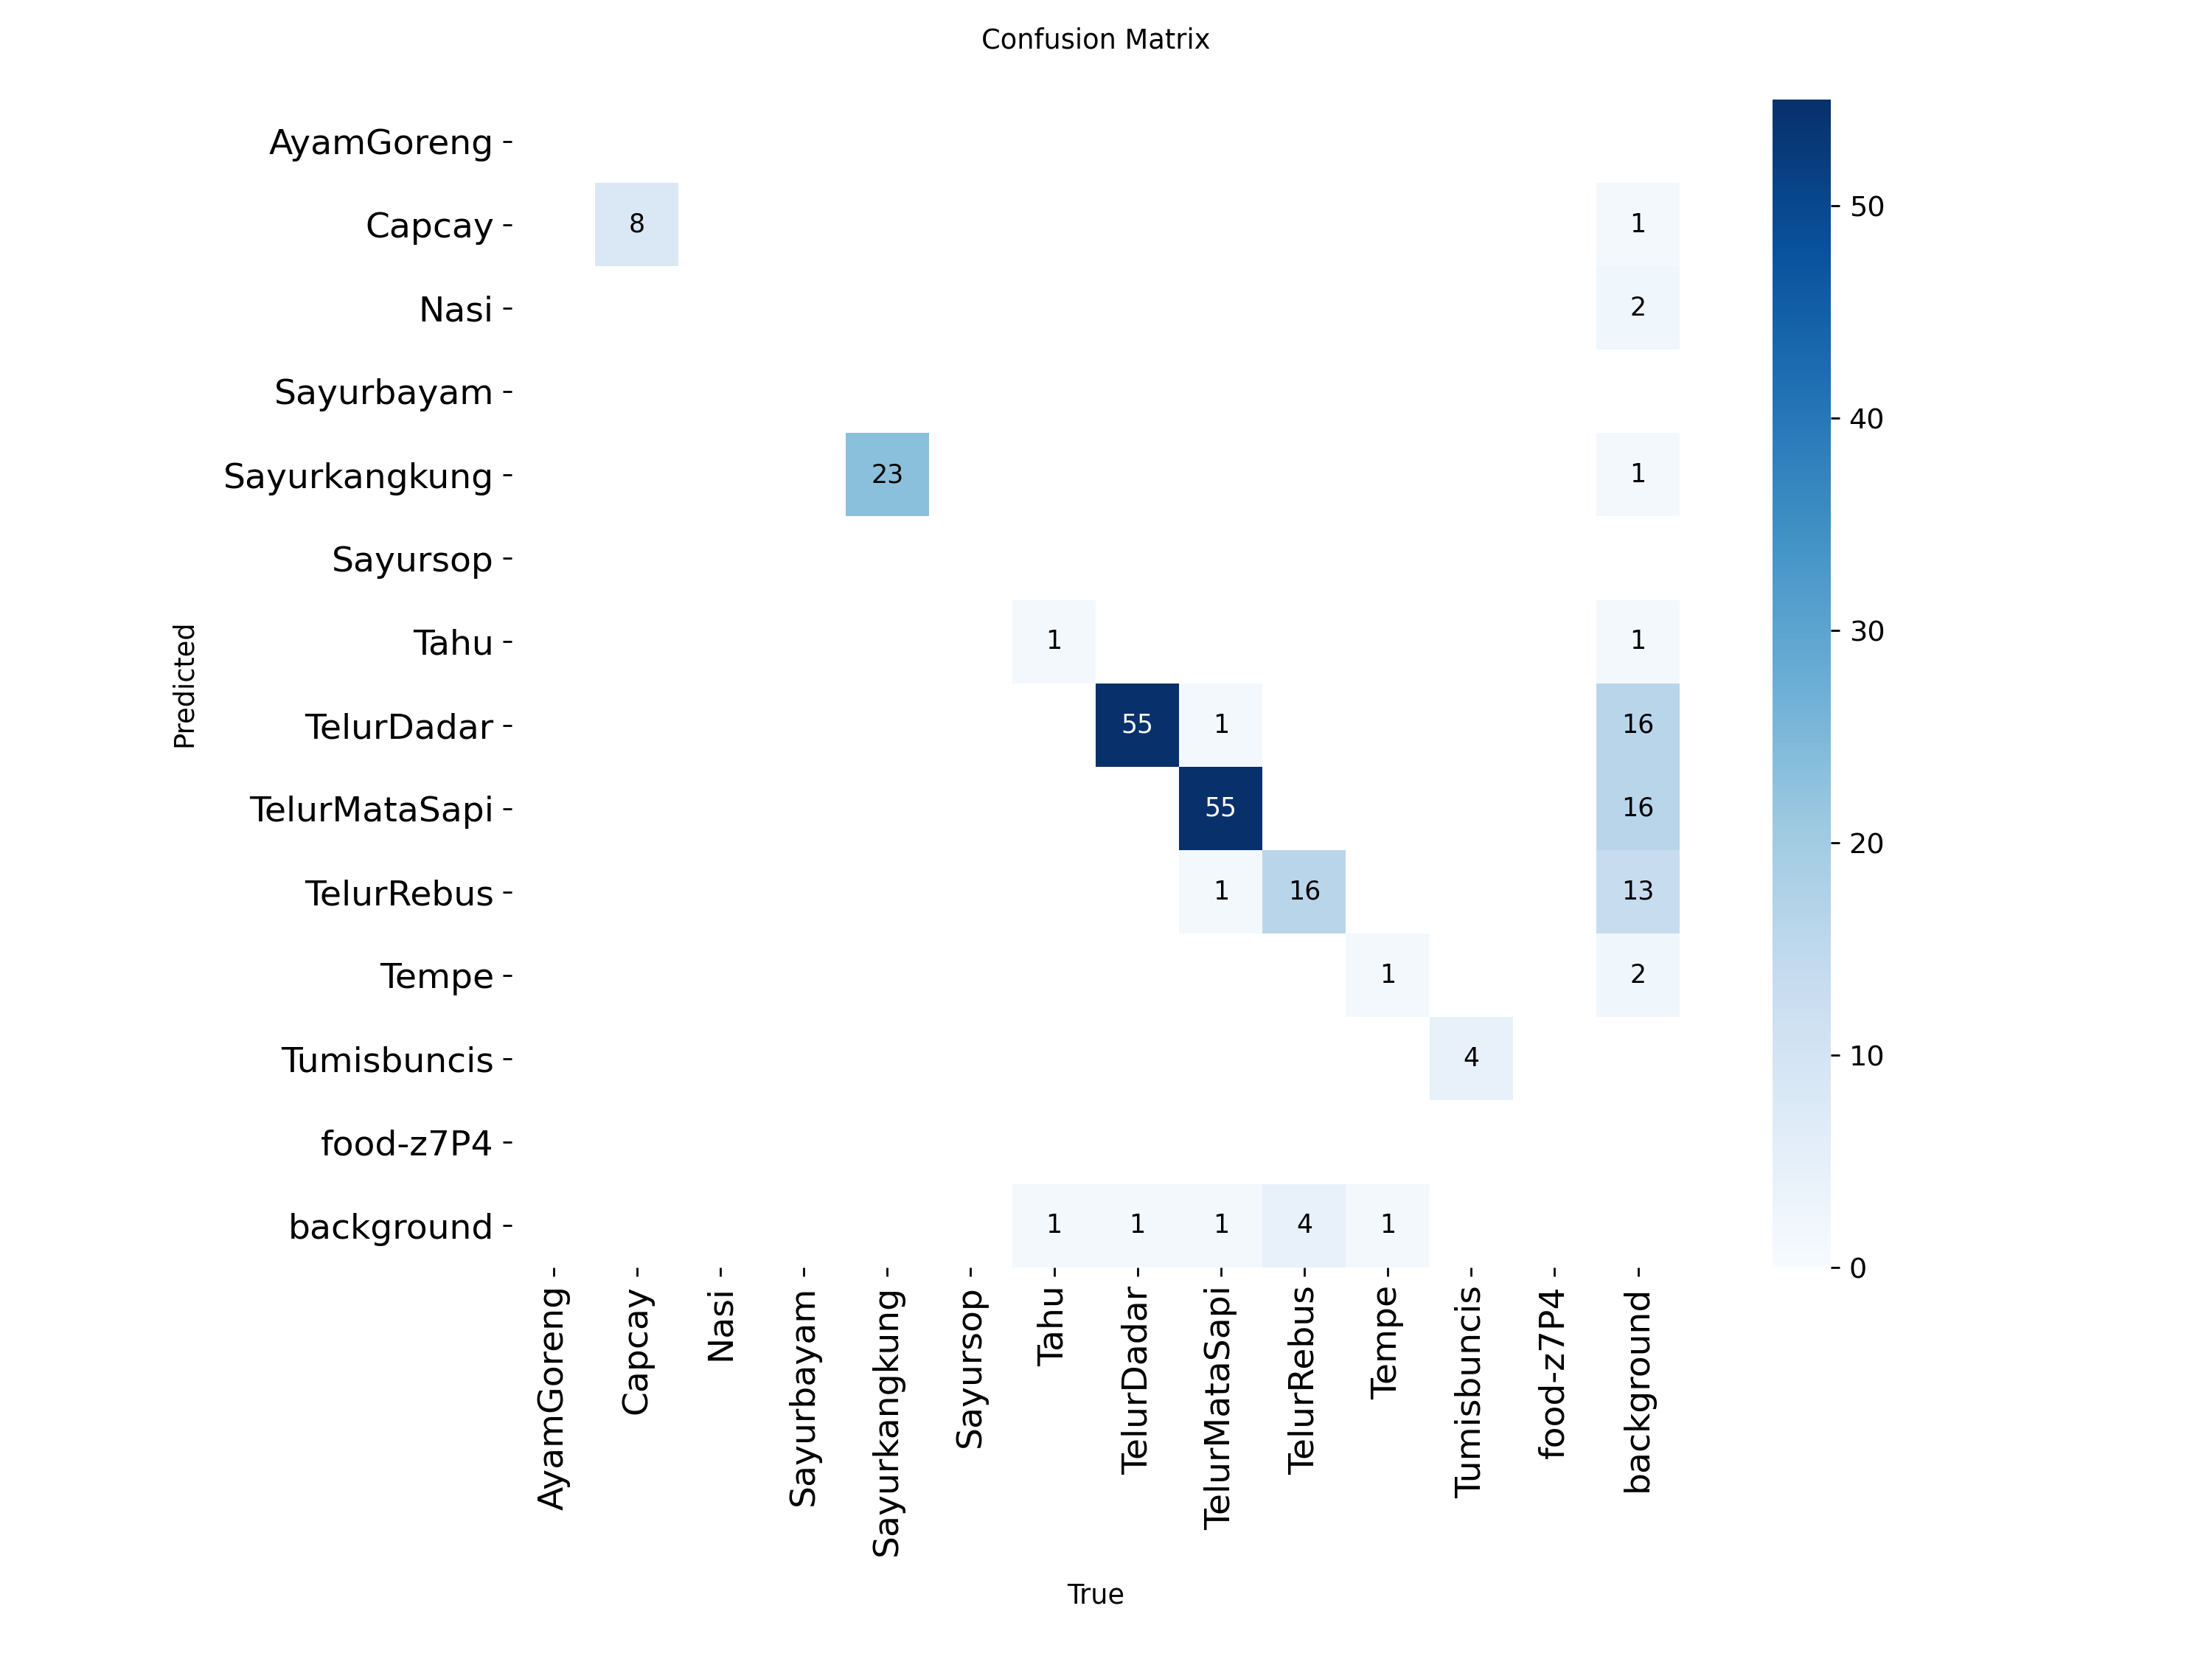

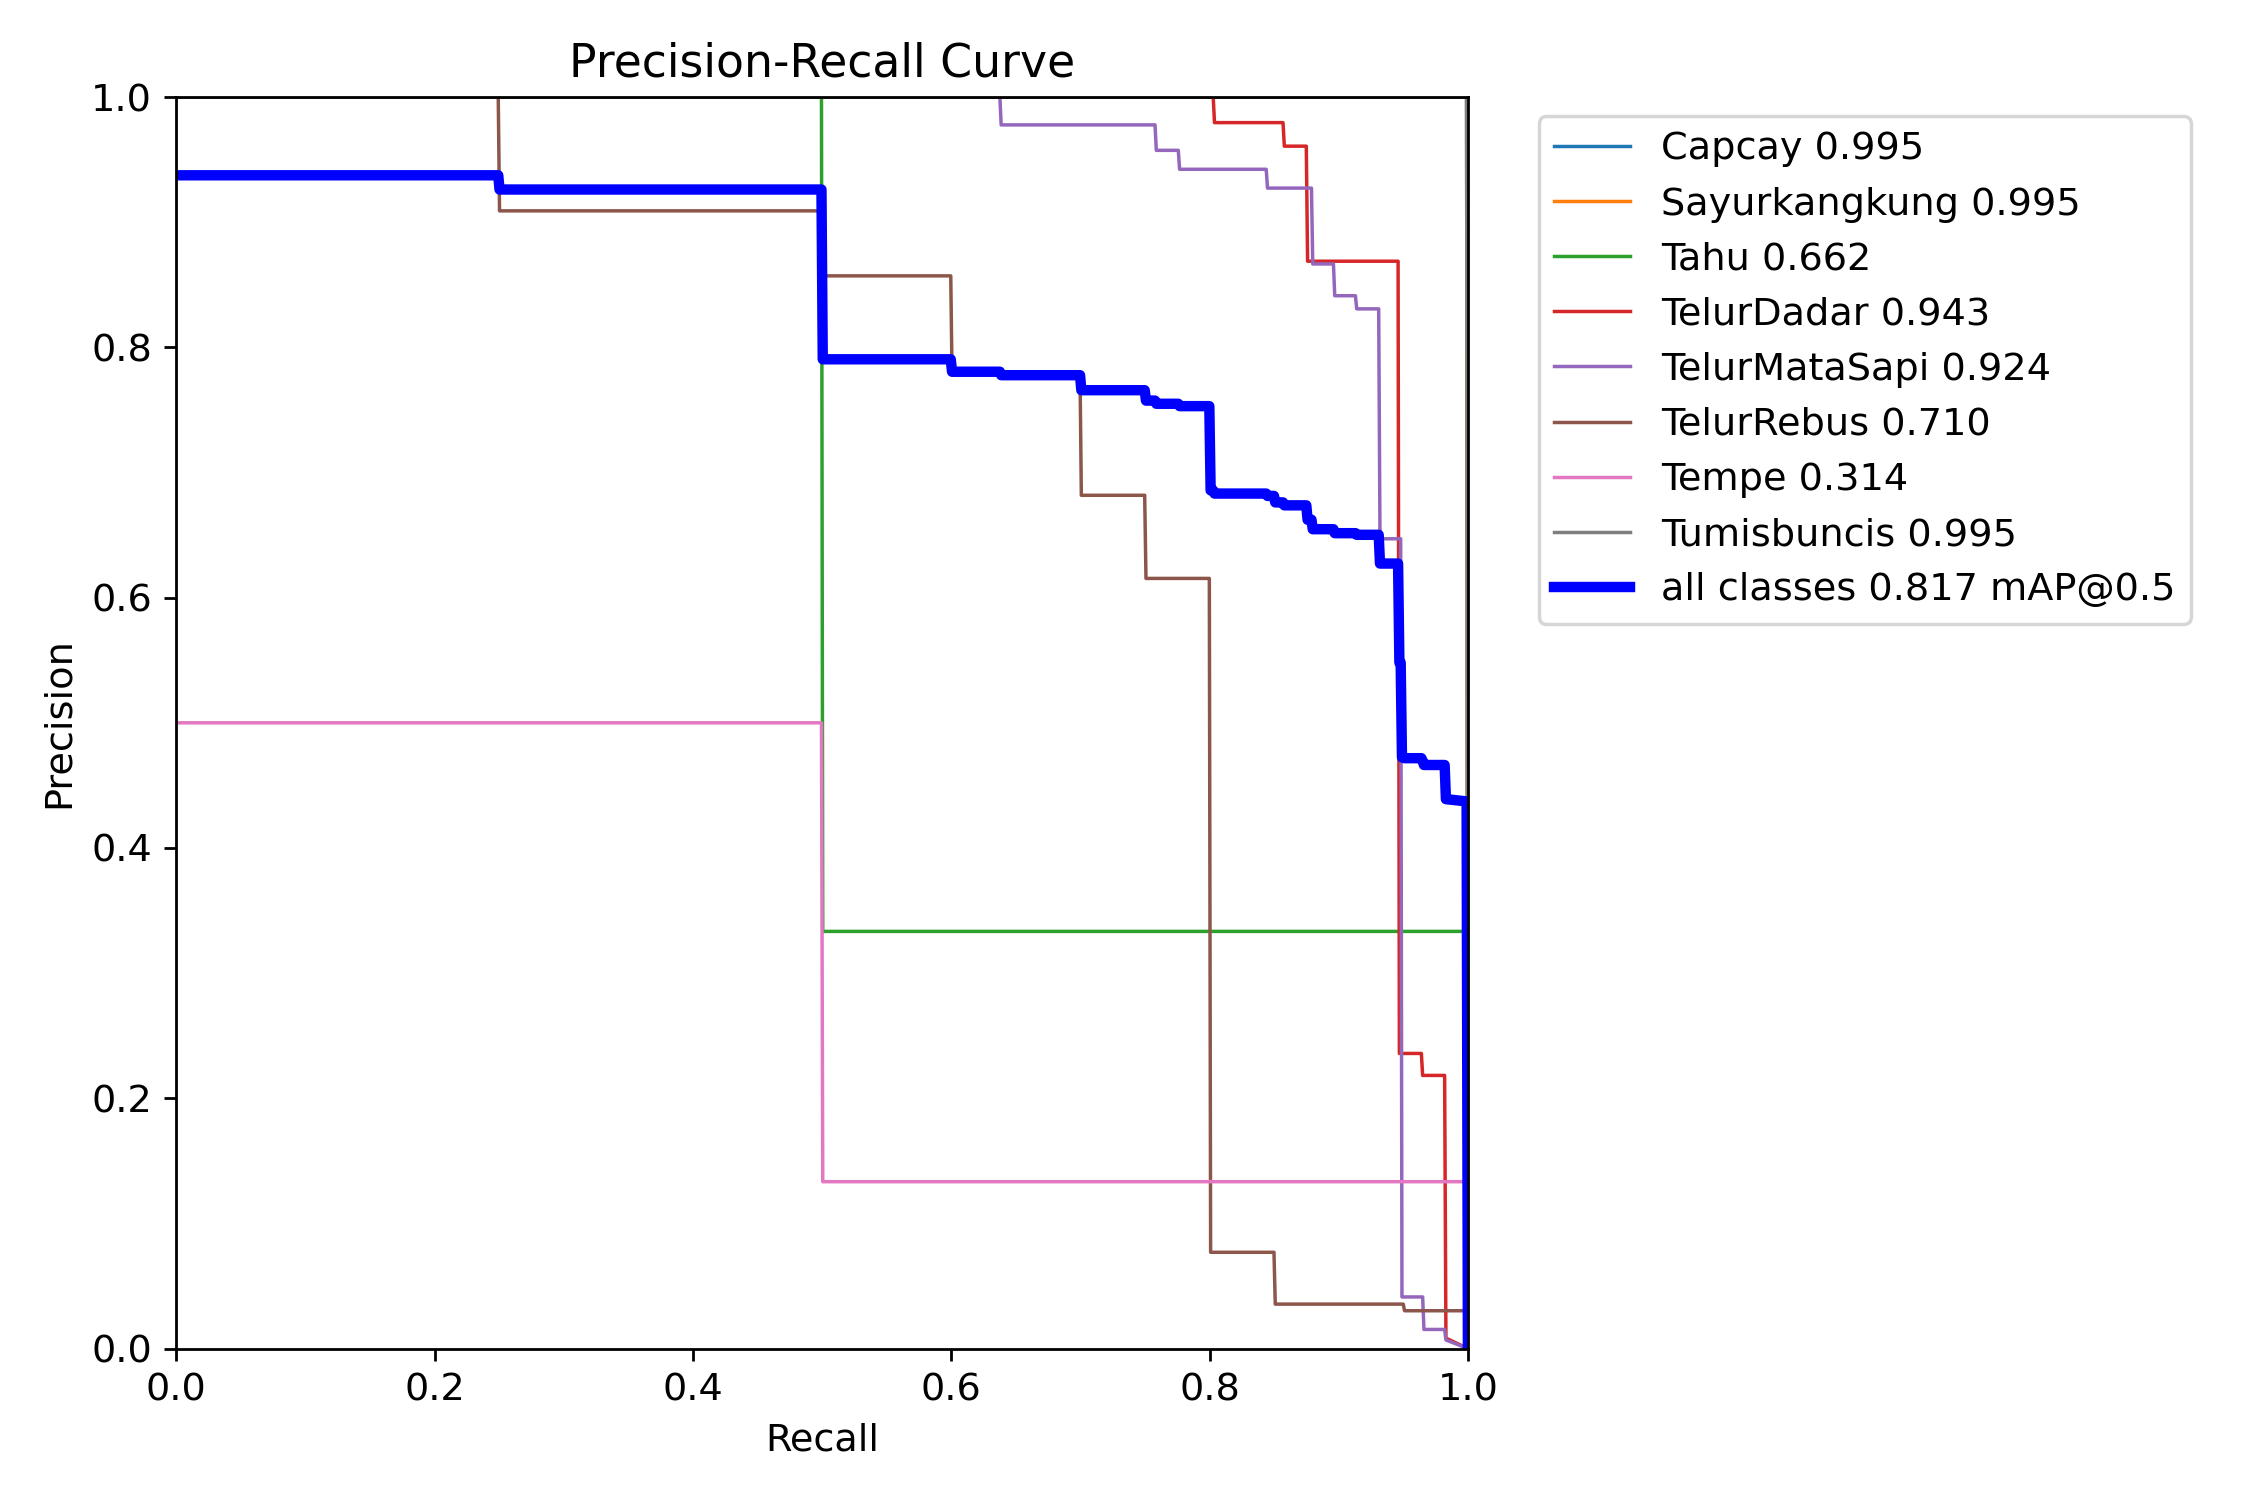

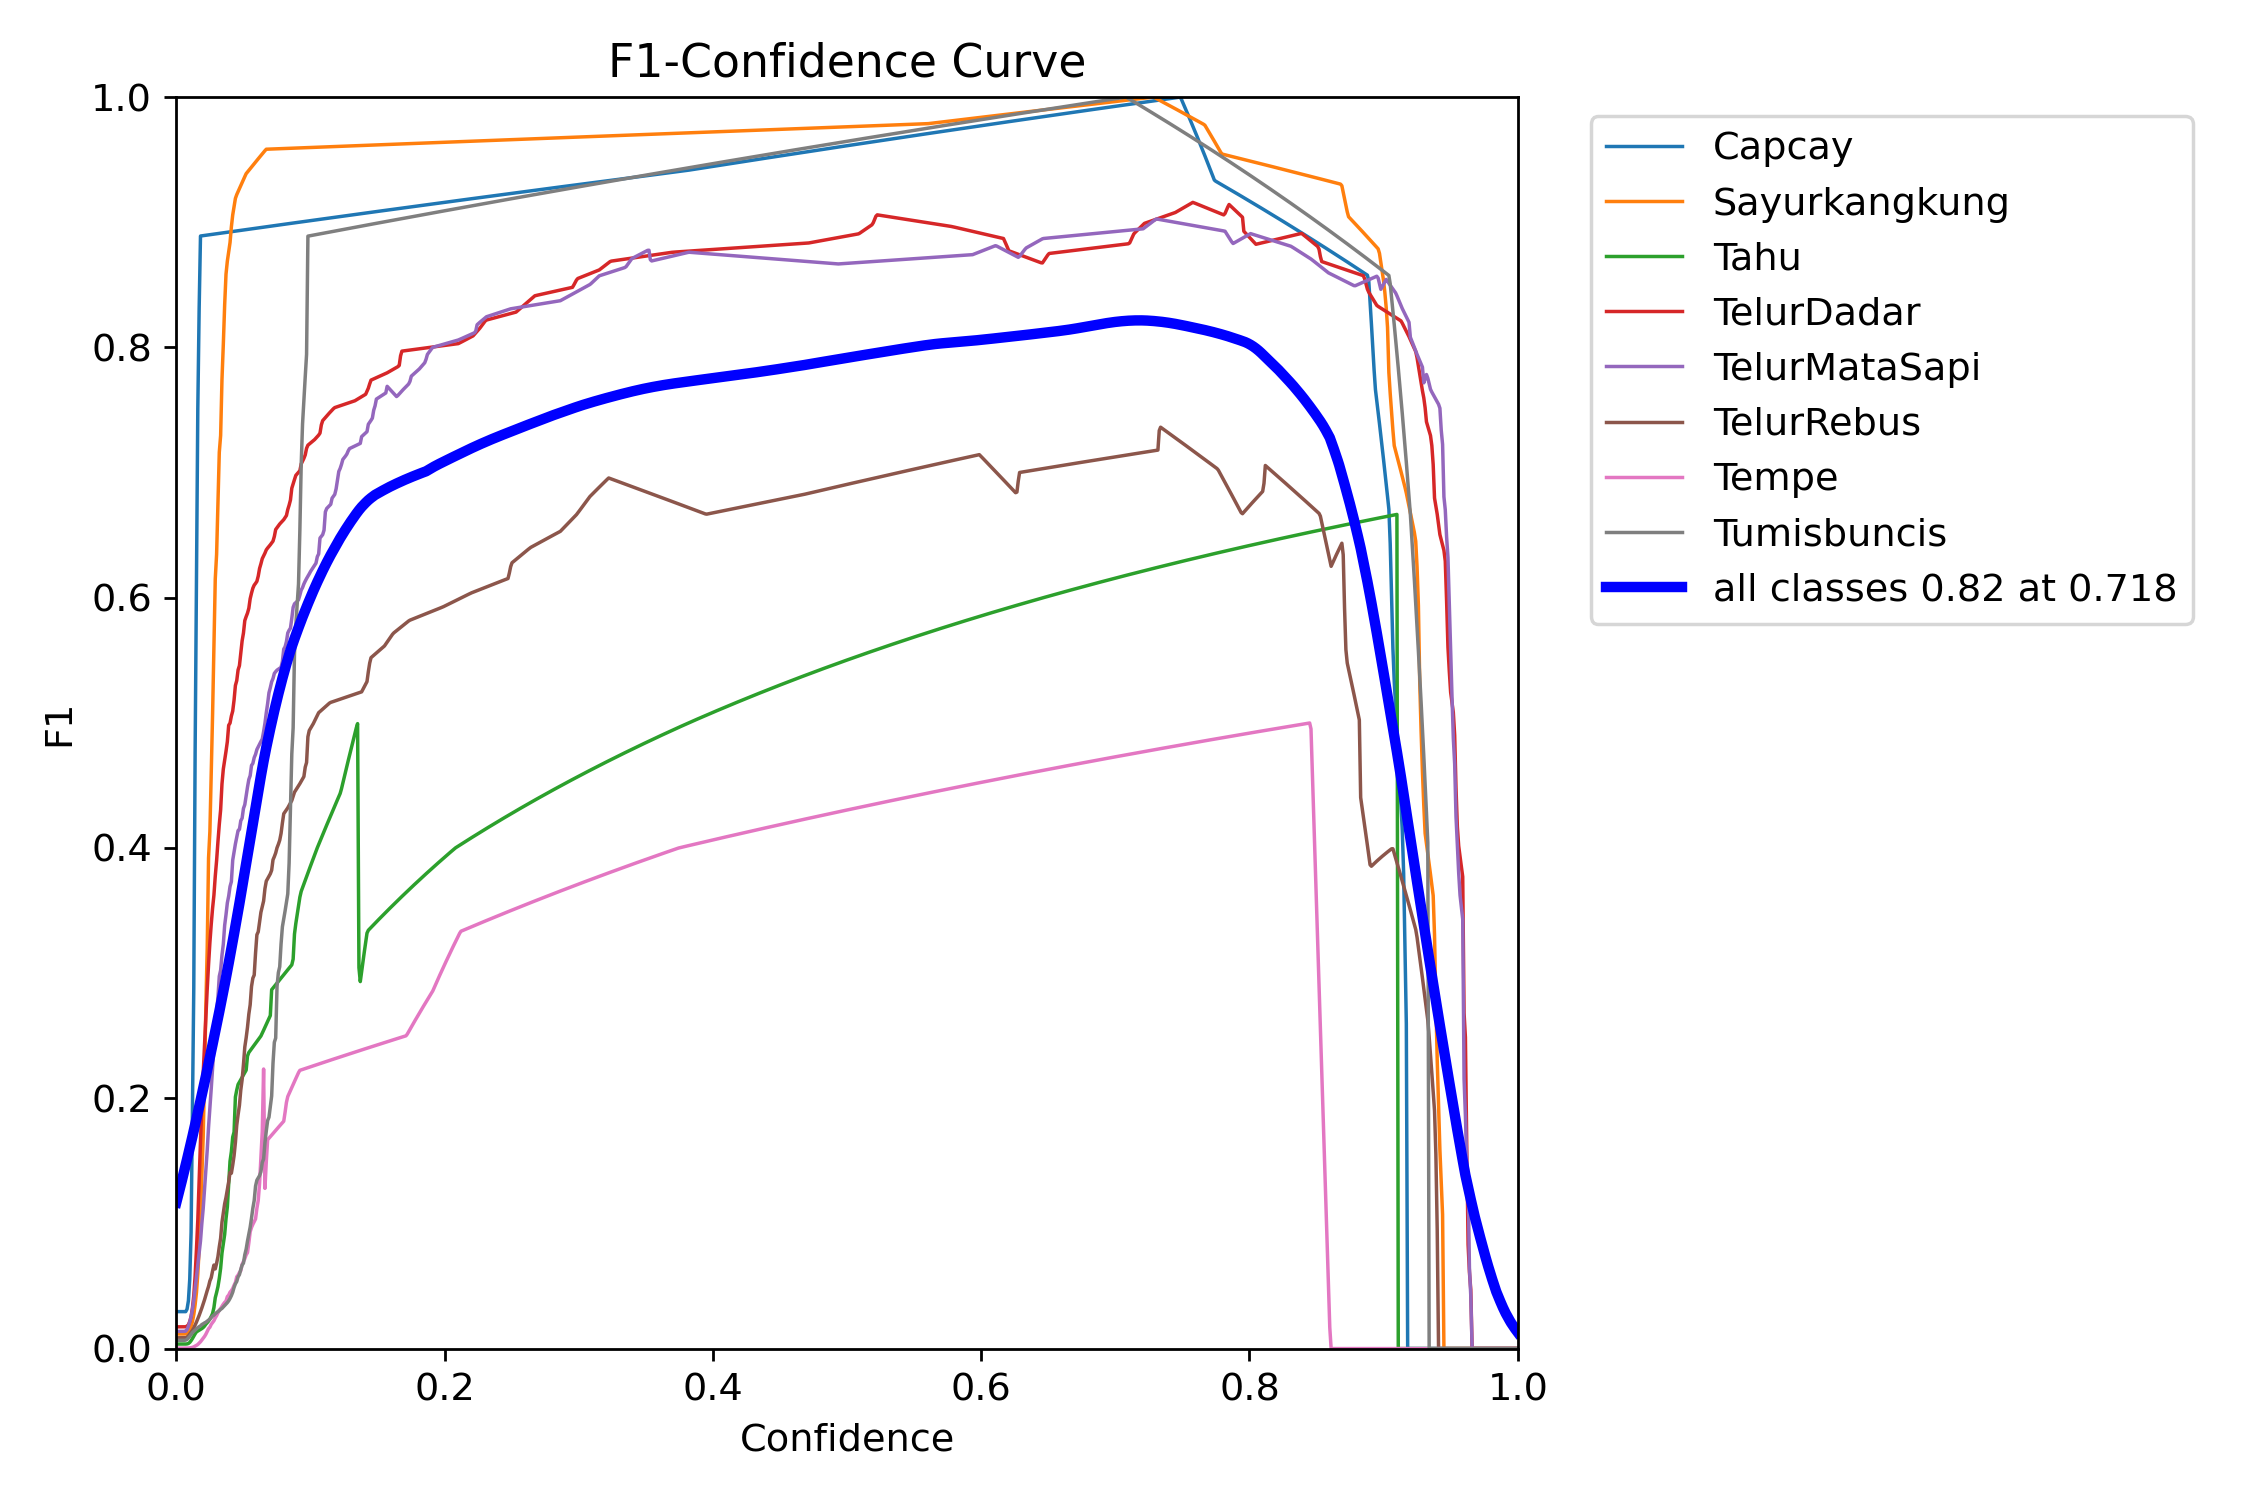

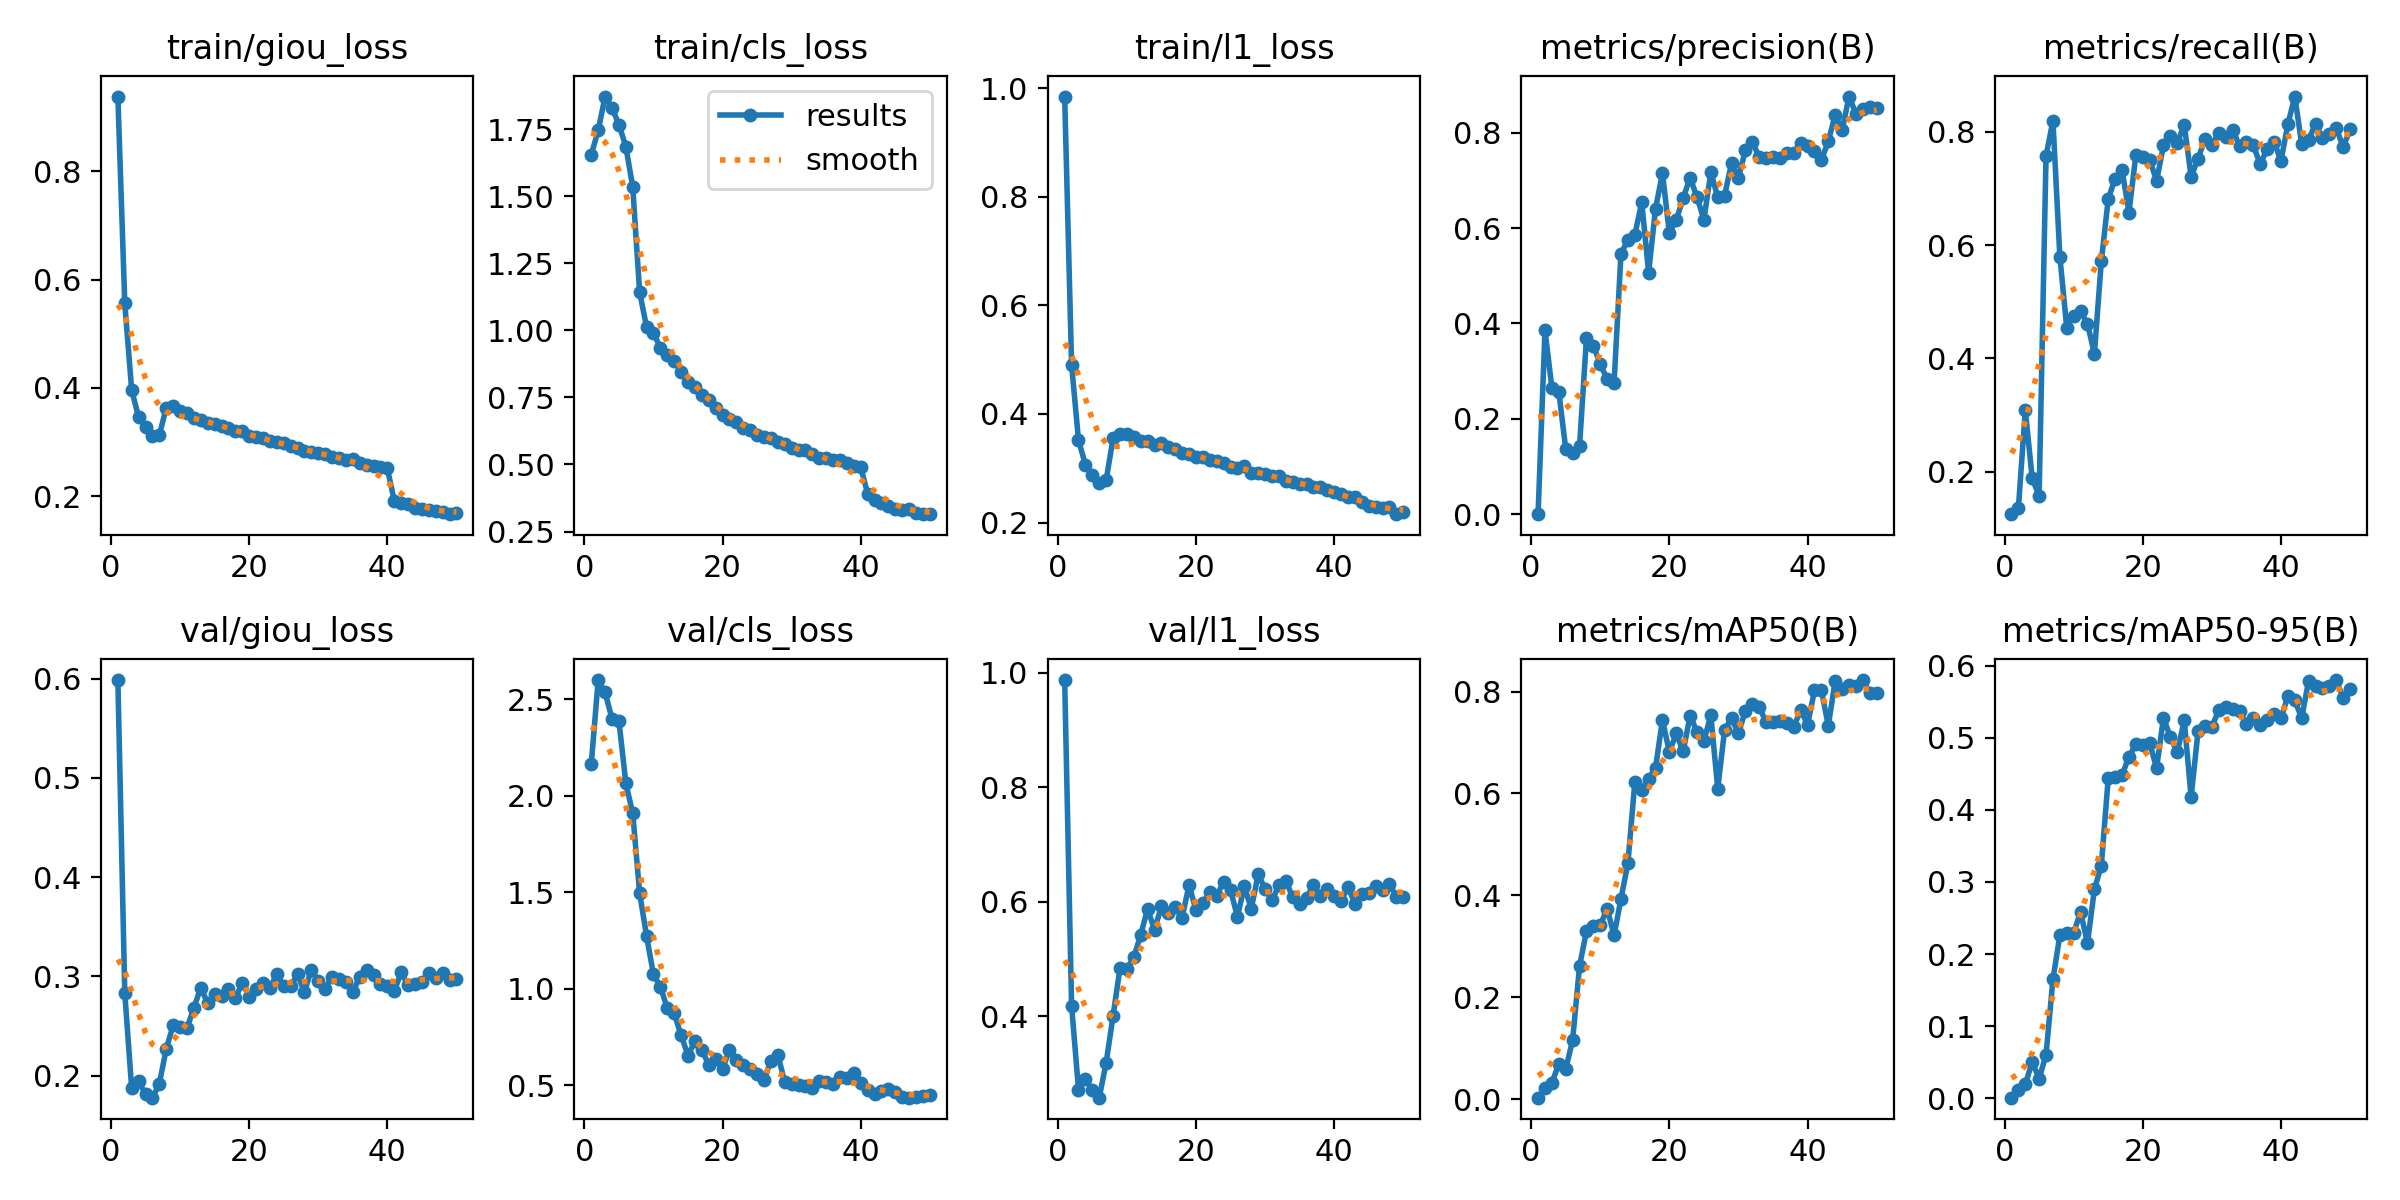

In [27]:
display(Image(filename='/content/runs/detect/train/confusion_matrix.png', width=800))

display(Image(filename='/content/runs/detect/train/BoxPR_curve.png', width=800))

display(Image(filename='/content/runs/detect/train/BoxF1_curve.png', width=800))

display(Image(filename='/content/runs/detect/train/results.png', width=900))

In [28]:
cls_names = model.model.names
df_metric = pd.DataFrame({
        'class'   : [cls_names[i] for i in range(len(cls_names))],
        'mAP@0.5' : results.box.maps
})
print('\nPer-class mAP@0.5')
print(df_metric.round(3))


Per-class mAP@0.5
            class  mAP@0.5
0      AyamGoreng    0.550
1          Capcay    0.688
2            Nasi    0.550
3      Sayurbayam    0.550
4   Sayurkangkung    0.631
5        Sayursop    0.550
6            Tahu    0.474
7      TelurDadar    0.751
8   TelurMataSapi    0.687
9      TelurRebus    0.517
10          Tempe    0.063
11    Tumisbuncis    0.585
12      food-z7P4    0.550


In [29]:
calorie_dict = {0:260, 1:67, 2:129, 3:36, 4:98, 5:22,
                6:80, 7:93, 8:110, 9:78, 10:225, 11:65, 12:0}


0: 640x640 1 TelurMataSapi, 86.4ms
Speed: 2.5ms preprocess, 86.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 TelurMataSapi, 73.9ms
Speed: 2.3ms preprocess, 73.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 TelurDadar, 77.8ms
Speed: 4.4ms preprocess, 77.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 TelurDadar, 73.6ms
Speed: 3.3ms preprocess, 73.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 TelurDadar, 74.6ms
Speed: 3.3ms preprocess, 74.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


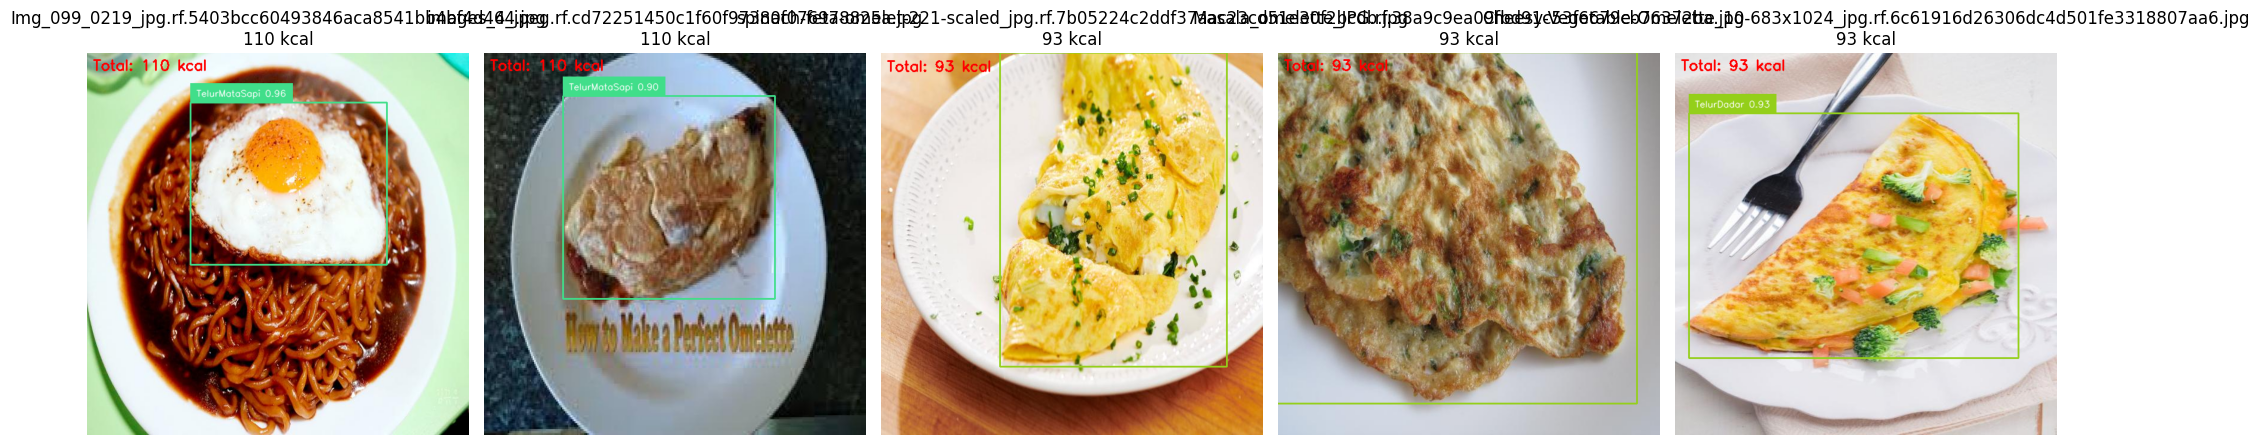

In [30]:
test_dir   = Path('/content/test/images')
save_vis   = Path('/content/test_vis')
save_vis.mkdir(exist_ok=True)


box_annotator   = sv.BoxAnnotator(thickness=2)
label_annotator = sv.LabelAnnotator(text_scale=0.5)

sample_imgs = list(test_dir.glob('*'))[:5]
fig, axes = plt.subplots(1, 5, figsize=(20, 10))

for ax, img_path in zip(axes, sample_imgs):
    im0   = cv2.imread(str(img_path))
    preds = model(im0, conf=0.35, iou=0.45)[0]
    det   = sv.Detections.from_ultralytics(preds)

    cls_ids = det.class_id
    counts  = np.bincount(cls_ids, minlength=13)
    total_cal = sum(counts[i] * calorie_dict[i] for i in range(13))

    labels_box = [f"{model.names[cid]} {conf:.2f}"
                  for cid, conf in zip(det.class_id, det.confidence)]

    annotated = box_annotator.annotate(im0.copy(), det)
    annotated = label_annotator.annotate(annotated, det, labels_box)

    cv2.putText(annotated, f"Total: {total_cal} kcal",
                (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,255), 2)

    ax.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    ax.set_title(f"{img_path.name}\n{total_cal} kcal")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [31]:
rows = []
for img_path in test_dir.glob('*'):
    im0   = cv2.imread(str(img_path))
    det   = sv.Detections.from_ultralytics(model(im0, conf=0.35)[0])
    counts = np.bincount(det.class_id, minlength=13)
    total  = sum(counts[i] * calorie_dict[i] for i in range(13))
    rows.append({'file': img_path.name, 'total_cal': total,
                 **{model.names[i]: counts[i] for i in range(13)}})
df_test = pd.DataFrame(rows)


0: 640x640 1 TelurMataSapi, 97.2ms
Speed: 2.0ms preprocess, 97.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 TelurMataSapi, 69.4ms
Speed: 2.9ms preprocess, 69.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 TelurDadar, 78.9ms
Speed: 1.9ms preprocess, 78.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 TelurDadar, 68.6ms
Speed: 2.4ms preprocess, 68.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 TelurDadar, 62.5ms
Speed: 4.6ms preprocess, 62.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 TelurDadars, 66.5ms
Speed: 1.8ms preprocess, 66.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 TelurMataSapi, 66.5ms
Speed: 1.8ms preprocess, 66.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 TelurDadar, 61.5ms
Speed: 2.4ms preprocess, 61.5ms inference, 0.9m